In [730]:
import bs4,pandas,math,os,random,time,requests

## How many bridge allisions with vessels over TK tons? Over time? What happens?

LOAD_FILE = "data/source/IIR/IIR_search.csv"
LOAD_CASUALTIES = "data/source/IIR/IIR_casualties.json"
LOAD_DAMAGES = "data/source/IIR/IIR_damages.csv"
LOAD_SUMMARY = "data/source/IIR/IIR_summary.csv"
LOAD_BRIEF = "data/source/IIR/IIR_brief.json"

LOAD_FACILITIES = "data/source/IIR/IIR_facilities.csv"
LOAD_VESSELS = "data/source/IIR/IIR_vessels.csv"

MAIN_CRS = 4326

activities = pandas.read_csv(LOAD_FILE, encoding="utf-8",parse_dates=["start_dt","end_dt"],dtype={"activity_id":int})
casualties = pandas.read_json(LOAD_CASUALTIES, lines=True, encoding="utf-8")
damages = pandas.read_csv(LOAD_DAMAGES, encoding="utf-8")
summary = pandas.read_csv(LOAD_SUMMARY, encoding="utf-8",index_col=0)
brief = pandas.read_json(LOAD_BRIEF, lines=True, encoding="utf-8")
waterseg = pandas.read_csv(LOAD_WATERSEG,encoding="utf-8")
facilities = pandas.read_csv(LOAD_FACILITIES, encoding="utf-8",dtype={"activity_id":int})
vessels = pandas.read_csv(LOAD_VESSELS, encoding="utf-8")

master_iir = activities.join(casualties.set_index("activity_id"), on="activity_id").join(damages.set_index("activity_id"), on="activity_id").join(summary.set_index("activity_id"), on="activity_id").join(brief.set_index("activity_id"), on="activity_id")

def dict_from_cols(row, cols):
    return_dict = {}
    for col in cols:
        value = row[col]
        if type(value) == str:
            value = value.strip().lower()
        return_dict[col] = value
    return return_dict

def tuple_from_cols(row, cols):
    return tuple([str(row[col]).lower() for col in cols])


vessels["vessel_tuple"] = vessels.apply(lambda x: dict_from_cols(x,["vessel_name","primary_vessel_id"]), axis=1)
vessels_by_activity = vessels.groupby("activity_id")["vessel_tuple"].apply(lambda x: list(x))
vessel_names_by_activity = vessels.groupby("activity_id")["vessel_name"].apply(lambda x: list(x))
vessel_ids_by_activity = vessels.groupby("activity_id")["primary_vessel_id"].apply(lambda x: list(x))

def allision_related(row):
    title = str(row["title"]).lower()
    brief = str(row["brief"]).lower()
    return (("allision" in title) or ("allide" in title) or ("allision" in brief) or ("allide" in brief))

def make_list_str(ls):
    return_str = ""
    if type(ls) == list:
        if len(ls)>0:
            for item in ls:
                return_str += str(item).replace(",",";").lower().strip() + ","
            return return_str[:-1]
    return return_str

facilities["nametype_tuple"] = facilities.apply(lambda x: dict_from_cols(x,["facility_name","facility_type"]), axis=1)
facilities_by_activity = facilities.groupby("activity_id")["nametype_tuple"].apply(list)
facility_names_by_activity = facilities.groupby("activity_id")["facility_name"].apply(list)
facility_names_by_activity = facility_names_by_activity.rename("facility_name_ls")


master_iir = master_iir.join(vessel_ids_by_activity, on="activity_id").join(vessel_names_by_activity, on="activity_id").join(facility_names_by_activity,on="activity_id")#.join(facilities_by_activity, on="activity_id")#.join(vessel_ids_by_activity, on="activity_id").join(facility_names_by_activity, on="activity_id").join(vessel_names_by_activity, on="activity_id")#.join(geo_waterseg.set_index("activity_id"),on="activity_id")
#master_iir = master_iir.join(vessel_names_by_activity, on="activity_id").join(vessel_ids_by_activity, on="activity_id")
#master_iir["facility_name"] = master_iir["facility_name"].apply(make_list_str)
master_iir["vessel_name"] = master_iir["vessel_name"].apply(make_list_str)
master_iir["vessel_id"] = master_iir["primary_vessel_id"].apply(make_list_str)
master_iir['year'] = pandas.to_datetime(master_iir["start_dt"]).apply(lambda x: x.year)

master_iir.to_csv("data/processed/IIR_master.csv", encoding="utf-8", index=False)


allisions = master_iir[(master_iir.apply(allision_related,axis=1))]
allisions.to_csv("data/processed/IIR_allisions.csv", encoding="utf-8", index=False)
facility_damage_allisions = allisions[allisions["facility_damage"]>0]
facility_damage_allisions.to_csv("data/processed/facility_damage_allisions.csv", encoding="utf-8", index=False)


In [732]:
facility_damage_allisions[~facility_damage_allisions["activity_id"].isin(geo_waterseg["activity_id"])].to_csv("data/processed/missing_coordinates.csv")

In [733]:
RR_KREG = [r'\bRR',r'\bRAIL', r'RAILROAD','R\\\R','R/R', 'R.R.']

def seems_like_railroad_bridge(facility_name):
    f_upper = str(facility_name).upper()
    for rr in RR_KREG:
        if re.search(rr,f_upper):
            return True
    return False

allision_facility_names = facilities[facilities["activity_id"].isin(allisions["activity_id"])]
allision_facility_names["railroad_bridge"] = allision_facility_names["facility_name"].apply(lambda x: seems_like_railroad_bridge(x))
allision_facility_names["facility_name_std"] = allision_facility_names["facility_name"].apply(lambda x: x.lower().strip())

rail_facilities = allision_facility_names[allision_facility_names["railroad_bridge"]==True]
other_facilities = allision_facility_names[allision_facility_names["railroad_bridge"]==False]


/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/715820497.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allision_facility_names["railroad_bridge"] = allision_facility_names["facility_name"].apply(lambda x: seems_like_railroad_bridge(x))
/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/715820497.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allision_facility_names["facility_name_std"] = allision_facility_names["facility_name"].apply(lambda x: x.lower().strip())


In [734]:
ALBERS_CONUS = 5070
ONE_MILE = 1609.34 #1 mile

def cluster_and_dissolve(gdf,buffer):
    gdf = gdf.to_crs(epsg=ALBERS_CONUS)
    gdf["buffer"] = gdf.buffer(buffer)
    gdf["geometry"] = gdf["buffer"]
    multi_p_series = geopandas.GeoSeries(gdf["buffer"].unary_union)
    polygons = multi_p_series.explode()
    clusters = geopandas.GeoDataFrame(geometry=polygons,crs=ALBERS_CONUS)
    clusters = clusters.to_crs(epsg=MAIN_CRS)
    clusters = clusters.reset_index()
    clusters = clusters.drop("level_0",axis=1).rename(columns={"level_1":"cluster_id"})
    return clusters

missing_coords = pandas.read_csv("data/manual/missing_coordinates--filled.csv")
waterseg = pandas.concat([waterseg,missing_coords])
geo_waterseg = geopandas.GeoDataFrame(waterseg,geometry=geopandas.points_from_xy(waterseg.long, waterseg.lat), crs="EPSG:4326")
state_boundaries = geopandas.read_file("data/source/tl_2023_us_state.zip").to_crs(MAIN_CRS)
county_boundaries = geopandas.read_file("data/source/tl_2023_us_county.zip").to_crs(MAIN_CRS)
geo_waterseg = geo_waterseg.sjoin(state_boundaries[["STUSPS","geometry"]],how="left",op="intersects").drop("index_right",axis=1).sjoin(county_boundaries[["GEOID","NAMELSAD","geometry"]],how="left",op="intersects").drop("index_right",axis=1)
geo_waterseg["county_state"] = geo_waterseg.apply(lambda x: str(x["NAMELSAD"])+";"+str(x["STUSPS"]),axis=1)
geo_allisions = geo_waterseg[geo_waterseg["activity_id"].isin(allisions["activity_id"])]#facility_damage_allisions["activity_id"])]
allision_clusters = cluster_and_dissolve(geo_allisions,ONE_MILE)
allisions_w_cluster = allision_clusters.sjoin(geo_allisions,how="inner",op="intersects").drop("index_right",axis=1)


/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/1265683764.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  pol

In [735]:
allisions_w_cluster.to_file("data/processed/geo_allisions.geojson", driver="GeoJSON")

In [737]:
# I realize this is ugly. I did a little slight of hand because a lot of things that seem like they ought to be complements are not.

def cluster_summary(df):
    temp = df.reset_index()
    df_summary_damage = df[df["facility_damage"]>0].groupby("cluster_id").agg({"activity_id":lambda x: list(x.unique()),"facility_damage":sum})
    df_summary_damage["n_activities"] = df_summary_damage["activity_id"].apply(len)
    temp = df_summary_damage.reset_index()
    df_summary_no_damage = df[~(df["facility_damage"]>0)].groupby("cluster_id").agg({"activity_id":lambda x: list(x.unique())})
    df_summary_no_damage["n_activities"] = df_summary_no_damage["activity_id"].apply(len)
    temp = df_summary_no_damage.reset_index()
    df_summary = df_summary_damage.join(df_summary_no_damage,lsuffix="_facility_damage",rsuffix="_no_damage",how="outer")
    temp = df_summary.reset_index()
    df_summary["facility_names"] = df.join(allision_facility_names.set_index("activity_id"),on="activity_id").groupby("cluster_id").agg({"facility_name_std":lambda x: list(x.unique())})
    df_summary["n_activities"] = df_summary["n_activities_facility_damage"].fillna(0) + df_summary["n_activities_no_damage"].fillna(0)
    df_summary["facility_names_listr"] = df_summary["facility_names"].apply(lambda x: make_list_str(x))
    df_summary["activity_ids_facility_damage_listr"] = df_summary["activity_id_facility_damage"].apply(lambda x: make_list_str(x))
    df_summary["activity_ids_no_damage_listr"] = df_summary["activity_id_no_damage"].apply(lambda x: make_list_str(x))
    return df_summary

cluster_data = allisions_w_cluster.join(allisions.set_index("activity_id"),on="activity_id")#facility_damage_allisions.set_index("activity_id"),on="activity_id")
cluster_counties = cluster_data.groupby(["cluster_id","geometry"]).agg({"year":max,"county_state":lambda x: list(x.unique())})
cluster_counties = cluster_counties.rename(columns={"year":"most_recent_year"})

rail_clusters = cluster_data[cluster_data["activity_id"].isin(rail_facilities["activity_id"])]
other_clusters = cluster_data[~(cluster_data["activity_id"].isin(rail_facilities["activity_id"]))]
rail_summary = cluster_summary(rail_clusters)
other_summary = cluster_summary(other_clusters)

both_summary = rail_summary.join(other_summary,lsuffix="_rail_bridge_names",rsuffix="_other_names",how="outer")
both_summary["n_activities_total"] = both_summary["n_activities_facility_damage_rail_bridge_names"].fillna(0) + both_summary["n_activities_facility_damage_other_names"].fillna(0) + both_summary["n_activities_no_damage_rail_bridge_names"].fillna(0) + both_summary["n_activities_no_damage_other_names"].fillna(0)
both_summary["facility_damage_total"] = both_summary["facility_damage_rail_bridge_names"].fillna(0) + both_summary["facility_damage_other_names"].fillna(0)

cluster_summary = cluster_counties.reset_index().set_index("cluster_id").join(both_summary,how="outer")
cluster_summary["county_state_listr"] = cluster_summary["county_state"].apply(make_list_str)
cluster_summary.sort_values("n_activities_total",ascending=False).to_csv("data/processed/cluster_summary.csv", encoding="utf-8")

/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/3632559652.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cluster_counties = cluster_data.groupby(["cluster_id","geometry"]).agg({"year":max,"county_state":lambda x: list(x.unique())})
/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/geopandas/tools/hilbert_curve.py:108: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/geopandas/tools/hilbert_curve.py:111: RuntimeWarning: invalid value encountered in cast
  return res.astype(np.uint32)
/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_739

In [738]:
temp = cluster_data.copy()#.to_file("data/processed/cluster_data.geojson", driver="GeoJSON")
temp["facility_name_ls"] = temp["facility_name_ls"].apply(make_list_str)
temp["primary_vessel_id"] = temp["primary_vessel_id"].apply(make_list_str)
temp.to_file("data/processed/cluster_data.geojson", driver="GeoJSON")

/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/fiona/collection.py:246: FeatureWarning: Empty field name at index 19
  self.session.start(self, **kwargs)


<Axes: >

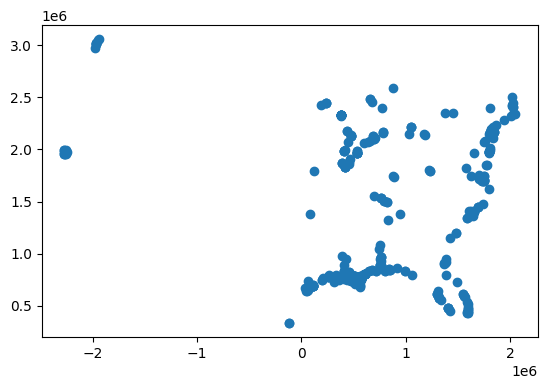

In [383]:
allision_facilities_reproj_points.plot()

In [275]:
facilities.groupby("facility_name")["facility_type"].nunique().sort_values()

facility_name
ST. JOSEPH RR BRIDGE                                 0
MATAGORDA SWING BRIDGE                               0
ROOSEVELT RD. BRIDGE                                 0
Duluth Ship Channel Wall (Underneath Lift Bridge)    0
NW 5TH ST BRIDGE, MIAMI RI                           0
                                                    ..
townsends inlet bridge (DUPLICATE)                   1
27TH STREET (MCALPINE LOCK) BRIDGE & DAM             2
Taylor Made Diagnostics                              2
FORE RIVER BRIDGE                                    2
NowCare  I                                           2
Name: facility_type, Length: 1295, dtype: int64

In [299]:
facilities[(facilities["facility_type"]!="Bridge")&(facilities["facility_name"].str.upper().str.contains("BRIDGE"))]

,activity_id,facility_name,facility_type,nametype_tuple
0,456,"NW 5TH ST BRIDGE, MIAMI RI",NaN,"{'facility_name': 'nw 5th st bridge, miami ri'..."
2,5382,Limehouse Bridge,NaN,"{'facility_name': 'limehouse bridge', 'facilit..."
3,9147,LOUISA BRIDGE,NaN,"{'facility_name': 'louisa bridge', 'facility_t..."
4,9656,MONITOR MERRIMAC BRIDGE TU,NaN,{'facility_name': 'monitor merrimac bridge tu'...
6,29659,PENSACOLA BEACH BRIDGE,NaN,"{'facility_name': 'pensacola beach bridge', 'f..."
...,...,...,...,...
3614,7603392,J.B. Marine Services-Bridge Fleet,Barge Fleeting Area,{'facility_name': 'j.b. marine services-bridge...
3616,7608414,Trailer Bridge,Waterfront Facility,"{'facility_name': 'trailer bridge', 'facility_..."
3628,7629160,27TH STREET (MCALPINE LOCK) BRIDGE & DAM,Lock/Dam,{'facility_name': '27th street (mcalpine lock)...
3681,7714239,"TRAILER BRIDGE, PUERTO RICO",Waterfront Facility,"{'facility_name': 'trailer bridge, puerto rico..."


In [ ]:
RR_KREG = [r'\bRR',r'\bRAIL', r'RAILROAD','R\\\R','R/R']

def seems_like_railroad_bridge(facility_name):
    f_upper = str(facility_name).upper()
    for rr in RR_KREG:
        if re.search(rr,f_upper):
            return True
    return False

facility_table = facilities.drop_duplicates(subset=["facility_name","facility_type"])
facility_table["facility_name_lower"] = facility_table["facility_name"].str.lower()
facility_table["railroad_bridge"] = facility_table["facility_name"].apply(seems_like_railroad_bridge)


#facility_table[["facility_name_lower","railroad_bridge"]].to_csv("data/processed/railroad_lookup.csv",index=False)

In [257]:
def blur_coords(lat,long):
    if lat is not None:
        return str(lat)[:6] +","+ str(long)[:6]

#temp = allisions.join(waterseg.set_index("activity_id"),on="activity_id")
allisions["latlong"] = allisions["lat"].astype(str) + "," + allisions["long"].astype(str)
allisions["blurred_latlong"] = allisions.apply(lambda x: blur_coords(x["lat"],x["long"]),axis=1)
state_count_per_facility_name = allisions[(allisions["facility_damage"]>0)].groupby("facility_name")["STUSPS"].nunique().sort_values()

state_count_per_facility_name[state_count_per_facility_name>1]

/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/3661127148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allisions["latlong"] = allisions["lat"].astype(str) + "," + allisions["long"].astype(str)
/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/3661127148.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allisions["blurred_latlong"] = allisions.apply(lambda x: blur_coords(x["lat"],x["long"]),axis=1)


facility_name
middle thorofare bridge                      2
barataria bridge,tom's marine and salvage    2
figure eight island bridge                   2
barataria bridge                             2
fore river bridge                            2
                                            ..
bayou sorrel bridge                          4
lacrosse railroad drawbridge                 4
csx rr bridge (200)                          4
bayou boeuf railroad bridge morgan city      6
bayou boeuf railroad bridge                  8
Name: blurred_latlong, Length: 72, dtype: int64

In [273]:
facility_damage_allisions.shape

(468, 36)

In [271]:
facility_damage_allisions[facility_damage_allisions["lat"].isna()]["facility_name"].unique()

array(['spuyten duyvil railroad bridge', 'barataria bridge',
       'baratria bridge', 'dularge bridge',
       'union pacific railroad bridge',
       'norfolk southern railroad bridge', 'csx blind rigolets rr bridge',
       'bayou boeuf railroad bridge', 'sisters creek bridge',
       'victoria barge canal r/r bridge', 'fort pierce north bridge',
       'caney creek swing bridge',
       'railroad bridge on carlin bayou/delcambr',
       'hwy bridge on cow bayou; west orange; mi',
       'gilmerton highway bridge,luck stone gilmerton yard',
       'kcs rr bridge on houston river; westlake',
       'escambia river bridge'], dtype=object)

In [249]:
temp = allisions[(allisions["facility_damage"]>0)&(allisions["railroad_bridge"]==False)].groupby("blurred_latlong")["facility_name"].nunique().sort_values()

temp[temp>1]

blurred_latlong
25.806,-80.25    2
28.870,-95.44    2
41.710,-83.42    2
38.951,-74.87    2
29.733,-90.12    2
29.944,-90.16    2
29.571,-90.71    2
30.342,-89.26    2
30.065,-93.34    2
29.384,-90.73    2
30.098,-90.91    2
30.156,-91.33    2
30.289,-91.31    2
30.082,-93.28    2
30.422,-91.19    3
29.571,-90.38    3
29.598,-90.71    3
29.970,-92.79    3
36.775,-76.29    3
nan,nan          9
Name: facility_name, dtype: int64

In [250]:
temp = allisions[(allisions["facility_damage"]>0)&(allisions["railroad_bridge"]==False)].groupby("latlong")["facility_name"].nunique().sort_values()

temp[temp>1]

latlong
30.289662,-91.31489                   2
28.87058,-95.444545                   2
29.598597,-90.710165                  2
41.71088,-83.42986                    2
29.38465,-90.73                       2
38.95189,-74.8759                     2
25.8069066666667,-80.2599883333333    2
29.9706,-92.79704                     3
29.57177,-90.38384                    3
30.42292,-91.19934                    3
nan,nan                               9
Name: facility_name, dtype: int64

In [ ]:
allisions[allisions["latlong"]=="30.42292,-91.19934"]["facility_name"].value_counts()

In [255]:
allisions[(allisions["blurred_latlong"]=="36.775,-76.29")&(allisions["facility_damage"]>0)]["facility_name"].value_counts()

facility_name
gilmerton bridge                             6
norfolk southern railway bridge 7            1
gilmerton bridge,moran towing of virginia    1
gilmerton highway bridge                     1
norfolk southern r/r bridge 7                1
Name: count, dtype: int64

In [213]:
allisions[(allisions["waterway_name"].isna())&(allisions["facility_damage"]>0)]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,description,lat,long,waterway_name,geometry,index_right,STUSPS,vessel_id,railroad_bridge,latlong
20,113842,MC01011866-WEEKS 202/ALLISION,2001-09-06,2004-02-02,3,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"284057,667434",True,"nan,nan"
28,152784,MC01010228-OSV ROSS CHOUEST/ALLISION,2001-08-02,2006-04-24,3,28.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"635043,650726,1040497",False,"nan,nan"
38,1480259,LADY LAFON,2002-01-22,2006-05-24,4,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,644058,False,"nan,nan"
65,1598663,M/V MR N BLANCHARD; Allision w/ Dularge Bridge,2002-03-22,2002-11-25,7,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,nan,False,"nan,nan"
73,1608318,BOB KOCH/ 151-ILR/ALLISION PEKIN RR,2002-04-16,2007-06-14,8,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"593419,598151",True,"nan,nan"
87,1628846,M/V HERMAN POTT Allision MI 61.2 Illinois River,2001-10-28,2004-12-15,9,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"545079,590177",True,"nan,nan"
116,1690826,M/V TYLER / BARATARIA BRIDGE ALLISION,2002-09-29,2007-09-25,12,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,574676,False,"nan,nan"
119,1705467,ANNETTE / Allision,2002-11-11,2006-10-03,12,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"255570,568166",True,"nan,nan"
147,1773447,M/V SUSAN MARIE & M/V MS MONIQUE,2003-04-12,2003-04-25,15,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"638315,530686,643781",True,"nan,nan"
1935,4199117,UTV AMERICAN / Allision / Expired COD,2011-10-24,2013-03-27,194,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"nan,1106163,647390,1226459",False,"nan,nan"


In [177]:
LOAD_WATERSEG = "data/source/IIR/IIR_water_segments.csv"


waterseg = pandas.read_csv(LOAD_WATERSEG,encoding="utf-8")
waterseg["latlong"] = str(waterseg["lat"]) +","+ str(waterseg["long"])
waterseg.groupby("activity_id")["latlong"].nunique().sort_values()

activity_id
456        1
5791477    1
5791897    1
5792153    1
5792208    1
          ..
3303989    1
3304100    1
3304826    1
3274725    1
7871448    1
Name: latlong, Length: 3502, dtype: int64

In [260]:
county_boundaries = geopandas.read_file("data/source/tl_2023_us_county.zip")
county_boundaries.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [262]:
county_boundaries

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."


In [266]:
import geopandas

geo_waterseg = geopandas.GeoDataFrame(waterseg,geometry=geopandas.points_from_xy(waterseg.long, waterseg.lat), crs="EPSG:4326")
state_boundaries = geopandas.read_file("data/source/tl_2023_us_state.zip")
county_boundaries = geopandas.read_file("data/source/tl_2023_us_county.zip")
joined = geo_waterseg.sjoin(state_boundaries[["STUSPS","geometry"]],how="left",op="intersects").drop("index_right",axis=1).sjoin(county_boundaries[["GEOID","NAMELSAD","geometry"]],how="left",op="intersects").drop("index_right",axis=1)

joined

/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/geopandas/geodataframe.py:2187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/Users/172086/Library/CloudStorage/OneDrive-TheE.W.ScrippsCompany/Documents/GitHub/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is

,activity_id,waterway_role,description,lat,long,waterway_name,geometry,STUSPS,GEOID,NAMELSAD
0,456,Location,NW 5TH ST BRIDGE: MIAMI RIVER ...,25.778332,-80.206665,MIAMI RIVER,POINT (-80.20667 25.77833),FL,12086,Miami-Dade County
1,2994,Location,Aboard Vessel: UNNAMED (FL6039JR): INTRACOASTA...,27.616665,-80.366665,ATLANTIC INTRACOASTAL WATERWAY,POINT (-80.36666 27.61667),FL,12061,Indian River County
2,9656,Location,No Location Entered On MSIS,36.936666,-76.403333,JAMES RIVER,POINT (-76.40333 36.93667),VA,51700,Newport News city
3,16776,Location,"CAIRO, IL",43.823332,-91.255000,MISSISSIPPI RIVER,POINT (-91.25500 43.82333),WI,55063,La Crosse County
4,38557,Location,SEPARATION CONNECTION,34.500000,-114.366667,LAKE HAVASU,POINT (-114.36667 34.50000),AZ,04015,Mohave County
...,...,...,...,...,...,...,...,...,...,...
3518,7871028,Location,OHR MM608.7,38.278533,-85.821768,OHIO,POINT (-85.82177 38.27853),KY,21111,Jefferson County
3519,7871448,Location,"Parkersburg Railroad Bridge, OHR MM 184.7",39.271180,-81.565923,OHIO,POINT (-81.56592 39.27118),WV,54107,Wood County
3520,2528278,Location,NEW JERSEY INTRACOASTAL WATERWAY ...,38.951890,-74.875900,NEW JERSEY INTRACOASTAL WATERWAY,POINT (-74.87590 38.95189),NJ,34009,Cape May County
3521,7114724,Location,SEA BRIGHT BRIDGE/INCIDENT LOCATION,40.365790,-73.975729,Unnamed Bay or Estuary or Ocean in New Jersey,POINT (-73.97573 40.36579),NJ,34025,Monmouth County


In [116]:
allisions[["facility_name","railroad_bridge"]].drop_duplicates().to_csv("data/processed/rr_column.csv",index=False)

In [148]:
RR_KREG = [r'\bRR',r'\bRAIL', r'RAILROAD','R\\\R','R/R']

def seems_like_railroad_bridge(facility_name):
    f_upper = str(facility_name).upper()
    for rr in RR_KREG:
        if re.search(rr,f_upper):
            return True
    return False

facility_table = facilities.drop_duplicates(subset=["facility_name","facility_type"])
facility_table["facility_name_lower"] = facility_table["facility_name"].str.lower()
facility_table["railroad_bridge"] = facility_table["facility_name"].apply(seems_like_railroad_bridge)
facility_table[["facility_name_lower","railroad_bridge"]].to_csv("data/processed/railroad_lookup.csv",index=False)

/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/3688974463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facility_table["facility_name_lower"] = facility_table["facility_name"].str.lower()
/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/3688974463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facility_table["railroad_bridge"] = facility_table["facility_name"].apply(seems_like_railroad_bridge)


In [145]:
import pandas

tons = pandas.read_csv("data/source/PSIX/PSIX_tons.csv",dtype={"primary_vessel_id":str})
allision_vessels = allisions.explode("primary_vessel_id")#.join(tons.set_index("vessel_id"), on="primary_vessel_id")
allision_vessels_weight = allision_vessels.join(tons.set_index("primary_vessel_id"), on="primary_vessel_id")

facility_damage_allisions = allision_vessels_weight[(allision_vessels_weight["facility_damage"]>0)]

In [149]:
POUND_CONVERSION = {"Long Ton":2240,"Short Ton":2000,"Metric Ton":2204.62,"Ton":2000}

def convert_to_pounds(row):
    if pandas.isna(row["measure_of_weight"]):
        return None
    return row["measure_of_weight"] * POUND_CONVERSION[row["unit_of_measure_name"]]

facility_damage_allisions["pounds"] = facility_damage_allisions.apply(convert_to_pounds,axis=1)
vessel_max_weights = facility_damage_allisions.groupby("primary_vessel_id")["pounds"].max()
#join to allisions, groupby facility, sum the weights

/var/folders/n1/qf74t1dj555cgs6f_mhz9nm0m6xrwl/T/ipykernel_73990/4029051622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facility_damage_allisions["pounds"] = facility_damage_allisions.apply(convert_to_pounds,axis=1)


In [154]:
facility_damage_allisions["railroad_bridge"].value_counts()

railroad_bridge
False    1138
True      822
Name: count, dtype: int64

In [157]:
# just group allisions by facility and find the count and the sum of the facility damage

temp = facility_damage_allisions[facility_damage_allisions["railroad_bridge"]==False].groupby("facility_name").agg({"facility_damage":"sum","activity_id":"nunique"})
temp.sort_values("activity_id",ascending=False)

,facility_damage,activity_id
facility_name,,
galveston causeway bridge,2505000.0,7
gilmerton bridge,1236877.0,7
bayou sorrel bridge,1113142.0,7
caney creek swing bridge,1099620.0,5
pelican island bridge,680000.0,4
...,...,...
"equilon enterprises llc d/b/a shell oil products,sunshine bridge",17500000.0,1
erie/jackknife bridge,40000.0,1
escambia river bridge,350000.0,1


In [21]:
facility_damage_allision_vessels_weight[facility_damage_allision_vessels_weight["pounds"]>=100000]

# then group by facility id and find out which bridges have had the most damage-doing allisions

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,brief,vessel_name,primary_vessel_id,vessel_id,measure_of_weight,tonnage_type_id,tonnage_type_name,unit_of_measure_id,unit_of_measure_name,pounds
79,1618443,Allision between the barge McKeesons & CSX RR ...,2002-05-18,2005-10-07,8,0.0,NaN,NaN,NaN,NaN,...,While transiting the St. Joseph River enroute ...,"mckee sons,invincible",610267,"247490,610267",90.0,4.0,Simplified,111.0,Short Ton,180000.0
79,1618443,Allision between the barge McKeesons & CSX RR ...,2002-05-18,2005-10-07,8,0.0,NaN,NaN,NaN,NaN,...,While transiting the St. Joseph River enroute ...,"mckee sons,invincible",610267,"247490,610267",113.0,4.0,Simplified,64.0,Long Ton,253120.0
79,1618443,Allision between the barge McKeesons & CSX RR ...,2002-05-18,2005-10-07,8,0.0,NaN,NaN,NaN,NaN,...,While transiting the St. Joseph River enroute ...,"mckee sons,invincible",610267,"247490,610267",90.0,4.0,Simplified,111.0,Short Ton,180000.0
79,1618443,Allision between the barge McKeesons & CSX RR ...,2002-05-18,2005-10-07,8,0.0,NaN,NaN,NaN,NaN,...,While transiting the St. Joseph River enroute ...,"mckee sons,invincible",610267,"247490,610267",113.0,4.0,Simplified,64.0,Long Ton,253120.0
79,1618443,Allision between the barge McKeesons & CSX RR ...,2002-05-18,2005-10-07,8,0.0,NaN,NaN,NaN,NaN,...,While transiting the St. Joseph River enroute ...,"mckee sons,invincible",610267,"247490,610267",90.0,4.0,Simplified,111.0,Short Ton,180000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,7868478,SHAUNA KAY - Allision,2024-01-29,2024-03-04,363,0.0,NaN,NaN,NaN,NaN,...,NaN,"shauna kay,james t quigg,artemis",1101122,"1101122,537733,1331497",87621.0,5.0,Dead Weight,120.0,Ton,175242000.0
3629,7868478,SHAUNA KAY - Allision,2024-01-29,2024-03-04,363,0.0,NaN,NaN,NaN,NaN,...,NaN,"shauna kay,james t quigg,artemis",1101122,"1101122,537733,1331497",79702.0,1.0,Convention (Subpart B),64.0,Long Ton,178532480.0
3629,7868478,SHAUNA KAY - Allision,2024-01-29,2024-03-04,363,0.0,NaN,NaN,NaN,NaN,...,NaN,"shauna kay,james t quigg,artemis",1101122,"1101122,537733,1331497",46051.0,1.0,Convention (Subpart B),111.0,Short Ton,92102000.0
3629,7868478,SHAUNA KAY - Allision,2024-01-29,2024-03-04,363,0.0,NaN,NaN,NaN,NaN,...,NaN,"shauna kay,james t quigg,artemis",1101122,"1101122,537733,1331497",115832.0,6.0,Displacement,120.0,Ton,231664000.0


In [15]:
facility_damage_allision_vessels_weight["pounds"].describe()

count    1.082000e+03
mean     1.336848e+07
std      5.159142e+07
min      8.960000e+03
25%      2.016000e+04
50%      3.200000e+04
75%      8.064000e+04
max      6.882120e+08
Name: pounds, dtype: float64

In [396]:
SOAP_URL = "https://cgmix.uscg.mil/xml/PSIXData.asmx"
SOAP_HEADERS = {
    'Content-Type': 'text/xml; charset=utf-8',
}

def construct_particulars_payload(vessel_id):
    return f"""<?xml version="1.0" encoding="utf-8"?>
    <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
    <soap:Body>
        <getVesselParticulars xmlns="https://cgmix.uscg.mil">
        <VesselID>{vessel_id}</VesselID>
        </getVesselParticulars>
    </soap:Body>
    </soap:Envelope>"""

def find_item_in_soup(soup,item):
    return soup.find(item).text if soup.find(item) else None


def get_particulars(vessel_id):
    payload = construct_particulars_payload(vessel_id)
    response = requests.request("POST", SOAP_URL, data=payload,headers=SOAP_HEADERS)
    soup = bs4.BeautifulSoup(response.text,features="xml")
    vessel_particulars = soup.find_all("VesselParticulars")
    particulars = []
    for v in vessel_particulars:
        name = find_item_in_soup(v,"VesselName")
        call_sign = find_item_in_soup(v,"VesselCallSign")
        service_type = find_item_in_soup(v,"ServiceType")
        service_sub = find_item_in_soup(v,"ServiceSubType")
        status_lookup = find_item_in_soup(v,"StatusLookupName")
        construct_complete_year = find_item_in_soup(v,"ConstructionCompletedYear")
        out_of_service_date = find_item_in_soup(v,"OutOfServiceDate")
        identification = find_item_in_soup(v,"Identification")
        id_type_id = find_item_in_soup(v,"IdentificationTypeLookupId")
        id_type_name = find_item_in_soup(v,"IdentificationTypeLookupName")
        country = find_item_in_soup(v,"CountryLookupName")
        country_id = find_item_in_soup(v,"CountryLookupId")
        particulars.append({"vessel_name":name,
                            "call_sign":call_sign,
                            "service_type":service_type,
                            "service_sub":service_sub,
                            "status_lookup":status_lookup,
                            "construct_complete_year":construct_complete_year,
                            "out_of_service_date":out_of_service_date,
                            "identification":identification,
                            "id_type_id":id_type_id,
                            "id_type_name":id_type_name,
                            "country":country,
                            "country_id":country_id})
    return particulars

#requests.request("POST", SOAP_URL, data=construct_particulars_payload(217652), headers=SOAP_HEADERS).text
get_particulars(217652)

[{'vessel_name': 'EDMUND L',
  'call_sign': 'WDD3011',
  'service_type': 'Towing Vessel',
  'service_sub': 'Fleeting',
  'status_lookup': 'Laid Up',
  'construct_complete_year': '1983',
  'out_of_service_date': '2023-12-15T00:00:00-05:00',
  'identification': '659917',
  'id_type_id': '6',
  'id_type_name': 'Official Number (U.S.)',
  'country': 'UNITED STATES',
  'country_id': '176948'}]

In [176]:
SOAP_URL = "https://cgmix.uscg.mil/xml/IIRData.asmx"
SOAP_HEADERS = {
    'Content-Type': 'text/xml; charset=utf-8',
}

def find_item_in_soup(soup,item):
    return soup.find(item).text if soup.find(item) else None

def construct_orgs_payload(activity_id):
    return f"""<?xml version="1.0" encoding="utf-8"?>
            <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
            <soap:Body>
                <getIIRInvolvedOrganizations xmlns="https://cgmix.uscg.mil/xml/">
                <ActivityId>{activity_id}</ActivityId>
                </getIIRInvolvedOrganizations>
            </soap:Body>
            </soap:Envelope>"""

#requests.request("POST", SOAP_URL, data=construct_orgs_payload(6016615), headers=SOAP_HEADERS).text

def get_orgs(activity_id):
    payload = construct_orgs_payload(activity_id)
    response = requests.request("POST",SOAP_URL,data=payload,headers=SOAP_HEADERS)
    soup = bs4.BeautifulSoup(response.text,features="xml")
    orgs = []
    for org in soup.find_all("IIRInvolvedOrganizations"):
        name = find_item_in_soup(org,"Name")
        addr = find_item_in_soup(org,"Address")
        addr_type = find_item_in_soup(org,"AddressTypeLookupName")
        party_role = find_item_in_soup(org,"PartyRoleLookupName")
        org_dict = {"acitivity_id":activity_id,
                "name":name,
                "addr":addr,
                "addr_type":addr_type,
                "party_role":party_role}
        orgs.append(org_dict)
    return orgs

get_orgs(6016615)

[{'acitivity_id': 6016615,
  'name': 'CROUNSE CORPORATION',
  'addr': '400 MARINE WAY\nPADUCAH, Kentucky 42003\nUNITED STATES',
  'addr_type': 'Primary Place of Business',
  'party_role': 'Other'},
 {'acitivity_id': 6016615,
  'name': 'CROUNSE CORPORATION',
  'addr': '400 MARINE WAY\nPADUCAH, Kentucky 42003\nUNITED STATES',
  'addr_type': 'Primary Place of Business',
  'party_role': 'Other'},
 {'acitivity_id': 6016615,
  'name': 'CROUNSE CORPORATION',
  'addr': '400 MARINE WAY\nPADUCAH, Kentucky 42003\nUNITED STATES',
  'addr_type': 'Primary Place of Business',
  'party_role': 'Other'},
 {'acitivity_id': 6016615,
  'name': 'CROUNSE CORPORATION',
  'addr': '400 MARINE WAY\nPADUCAH, Kentucky 42003\nUNITED STATES',
  'addr_type': 'Primary Place of Business',
  'party_role': 'Other'},
 {'acitivity_id': 6016615,
  'name': 'SHAMBLIN STONE, INC',
  'addr': '70 DUNBAR AVE            \nPO BOX 510\nDUNBAR, West Virginia 25064\nUNITED STATES',
  'addr_type': 'Primary Place of Business',
  'party_

In [2]:
SEED = 0

allisions[(allisions["facility_damage"]>0)&(allisions["brief"].notna())].sample(30, random_state=SEED).to_csv("data/processed/IIR_allisions_sample.csv", encoding="utf-8", index=False)

<Axes: title={'center': 'Number of allisions per vessel'}, xlabel='primary_vessel_id'>

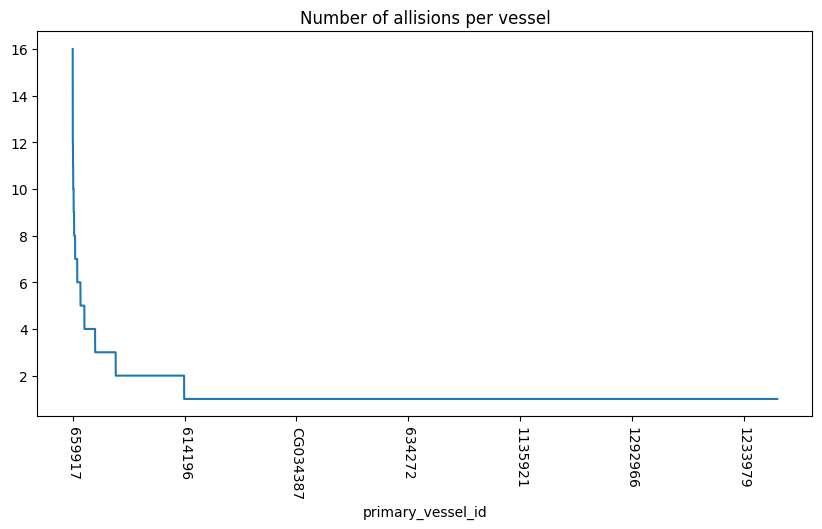

In [30]:
allisions_by_vessel = vessels[vessels["activity_id"].isin(allisions["activity_id"])].groupby(vessels["primary_vessel_id"])["activity_id"].count().sort_values(ascending=False)
allisions_by_vessel.plot(title="Number of allisions per vessel", figsize=(10,5), rot=-90)

In [49]:
vessels[vessels["primary_vessel_id"]=="659917"]

,activity_id,vessel_name,misle_vessel_id,primary_vessel_id,vessel_role,vessel_tuple
2199,2885010,EDMUND L,217652.0,659917,Involved in a Marine Casualty,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
2843,3121074,EDMUND L,217652.0,659917,Involved in a Marine Casualty,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
2856,3128282,EDMUND L,217652.0,659917,Involved in a Marine Casualty,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
2875,3134092,EDMUND L,217652.0,659917,Involved in a Marine Casualty,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
2951,3154868,EDMUND L,217652.0,659917,Involved in a Marine Investigation (non-casualty),"{'vessel_name': 'edmund l', 'primary_vessel_id..."
2954,3155455,EDMUND L,217652.0,659917,Involved in a Marine Investigation (non-casualty),"{'vessel_name': 'edmund l', 'primary_vessel_id..."
3293,3268399,EDMUND L,217652.0,659917,Involved in a Marine Casualty,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
3575,3420356,EDMUND L,217652.0,659917,Involved in a Marine Investigation (non-casualty),"{'vessel_name': 'edmund l', 'primary_vessel_id..."
3577,3421432,EDMUND L,217652.0,659917,Transiting Vicinity of Primary Subject,"{'vessel_name': 'edmund l', 'primary_vessel_id..."
3663,3444710,EDMUND L,217652.0,659917,Transiting Vicinity of Primary Subject,"{'vessel_name': 'edmund l', 'primary_vessel_id..."


<Axes: title={'center': 'Number of allisions per facility'}, xlabel='facility_name'>

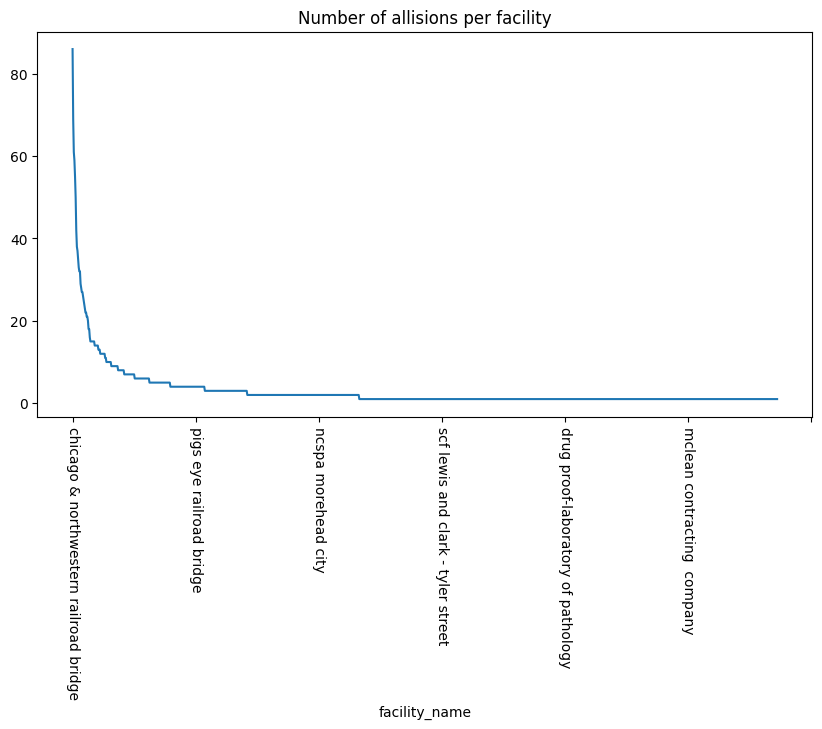

In [11]:
allisions_by_facility = facilities[facilities["activity_id"].isin(allisions["activity_id"])].groupby(facilities["facility_name"].str.lower().str.strip())["activity_id"].count().sort_values(ascending=False)
allisions_by_facility.plot(title="Number of allisions per facility", figsize=(10,5), rot=-90)

In [15]:
facilities[facilities["facility_name"].str.contains("scott key", case=False)]

,activity_id,facility_name,facility_type,nametype_tuple
648,2630298,Francis Scott Key Bridge,Bridge,"{'facility_name': 'francis scott key bridge', ..."


In [22]:
allisions_by_facility.head(30)

facility_name
chicago & northwestern railroad bridge     86
sabula railroad drawbridge                 69
burlington railroad drawbridge             61
louisiana railroad drawbridge              59
florence highway drawbridge                55
galveston causeway bridge                  50
elgin joliet & eastern rr drawbridge       42
lacrosse railroad drawbridge               38
cairo bridge                               37
melville railroad bridge                   35
naheola bridge                             33
bayou dularge bridge                       32
vicksburg railway and highway bridge       32
illinois central railroad bridge           29
bayou boeuf railroad bridge morgan city    28
crescent railroad drawbridge               27
bayou boeuf railroad bridge                27
johns pass bridge                          26
clinton railroad drawbridge                25
gilmerton highway bridge                   24
i-24 highway bridge                        23
louisville and nashv

In [28]:
chi_nw_rr_act = facilities[facilities["facility_name"].str.contains("chicago & northwestern railroad bridge", case=False)]["activity_id"].unique()

chi_nw_rr_allisions = allisions[allisions["activity_id"].isin(chi_nw_rr_act)]

print(chi_nw_rr_allisions.sample()["brief"].iloc[0])

The M/V Sheila Johnson was transiting S/B on the Illinois River at approximately 151.0 when the F/B SCNO-8135 allided with the Chicago & Northwestern RR Bridge. No damage was sustained to the towboat or bridge.  The barge F/B SCNO-8135 sustained minor damage and was shingled and resumed transit. 






In [ ]:
CONTAINERSHIP_WORDS = ["containership","container ship","tanker","freighter","cargo ship","cargo vessel","freight vessel"]

def containership_related(row):
    title = str(row["title"]).lower()
    brief = str(row["brief"]).lower()
    return any([word in title for word in CONTAINERSHIP_WORDS]) or any([word in brief for word in CONTAINERSHIP_WORDS])


<Axes: title={'center': "Coast guard investigations including the words\n'bridge' and 'allision/allide/allided' by year since 2002\n(recent years may be incomplete)"}, xlabel='start_year'>

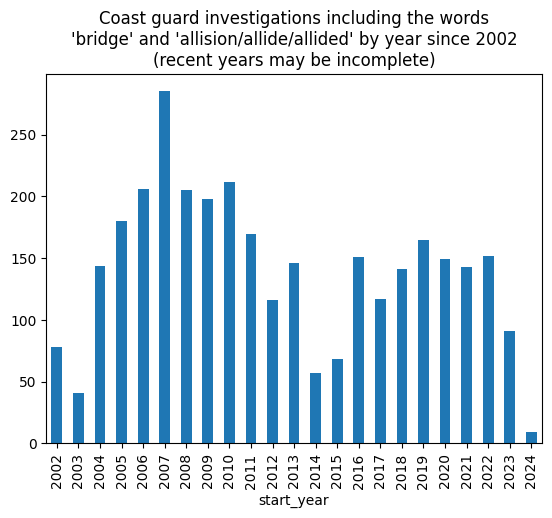

In [343]:
master_iir["start_year"] = master_iir["start_dt"].dt.year
allisions_since_2002 = master_iir[((master_iir["title"].str.contains("allision", case=False))|(master_iir["brief"].str.contains("allision",case=False))|(master_iir["brief"].str.contains("allide",case=False)))&(master_iir["start_year"]>=2002)]
allisions_since_2002["start_year"].value_counts().sort_index().plot(kind="bar", title="Coast guard investigations including the words\n'bridge' and 'allision/allide/allided' by year since 2002\n(recent years may be incomplete)")

In [366]:
master_iir[(master_iir["facility_damage"].notna()) & (master_iir["facility_damage"]>0) & (master_iir["brief"].notna())]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
19,112295,MC01005346-M/V FROSTY'S SLEIGH - ALLISION,2001-04-13,2004-12-06,2,7.0,NaN,NaN,NaN,NaN,...,1350000.0,0.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,"At approximately 1630 on April 13, 2001, the M...",2001
20,113842,MC01011866-WEEKS 202/ALLISION,2001-09-06,2004-02-02,3,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,UTV ELIZABETH with freight barge WEEKS 202 alo...,2001
24,138869,MC01013487-DORY BARKER/ALLISION,2001-10-16,2004-12-15,3,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"1. On 16 October 2001, a UTV towing two unloa...",2001
28,152784,MC01010228-OSV ROSS CHOUEST/ALLISION,2001-08-02,2006-04-24,3,28.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,On 02 AUG 01 the DELTA CAPTAIN with OSV ROSS C...,2001
30,176982,MC01011510-WEEKS 246/ALLISION W/BRIDGE,2001-08-23,2005-10-26,4,7.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,An uninspected towing vessel with a deck barge...,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,7623789,SPINDLETOP - Bridge Allision,2022-06-15,2023-05-22,351,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"On June 15, 2022 at approximately 2110 (CST), ...",2022
3529,7644239,RENEE T WHATLEY Allision,2022-12-31,2023-03-09,353,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"On December 31, 2022 at approximately 1201 loc...",2022
3539,7660491,RONALD E WAGENBLAST Allision,2023-03-24,2023-04-11,354,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,RONALD E WAGENBLAST was traveling northbound p...,2023
3549,7671615,COWBOY CARL - Bridge Allision,2023-04-18,2023-05-16,355,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"On 18 April 2023 at approximately 1455, the IT...",2023


In [356]:
master_iir[(master_iir.apply(containership_related,axis=1))&(master_iir.apply(allision_related,axis=1))]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
0,456,MC01001713-SARA EXPRESS BRIDGE ALLISION,2001-02-03,2009-03-05,1,0.0,NaN,NaN,NaN,NaN,...,3000000.0,0.0,False,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,"APPROX 0040, 03FEB01, M/V SARA EXPRESS ALLIDED...",2001
8,52171,TANKER NARIVA ALLISION WITH HILTON RR BRIDGE,2001-10-23,2006-05-04,1,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,23OCT01 (1515 local) MSO Wilmington OOD receiv...,2001
15,81167,TUG TED WAXLER/ALLISION,2001-08-15,2005-10-18,2,0.0,NaN,NaN,NaN,NaN,...,20987.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"On August 15th, 2001 the Tug TED WAXLER, pushi...",2001
17,94101,MC01011515-KTC-60 CHELSEA ST ALLISION,2001-09-05,2004-12-06,2,NaN,0.0,NaN,NaN,NaN,...,8000.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,While transiting outbound through the Chelsea ...,2001
50,1484363,AGIOS NEKTARIOS allision with McArdle Bridge,2002-02-06,2008-04-10,6,0.0,NaN,NaN,NaN,NaN,...,0.0,580248.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,CASUALTY SUMMARY\nOn 06 Feb 02 at approximatel...,2002
263,2087565,Bridge Allision Barge 30 w/ Hiem Bridge,2004-05-07,2005-02-16,27,0.0,NaN,NaN,NaN,NaN,...,0.0,60000.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,Bridge Allsion involving Foss Tug PT Vicente u...,2004
496,2518678,UTV CATHY M. SETTOON / Bridge Allision,2005-10-15,2007-11-20,50,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,111/05 \n\n10/15/2005 - UTV Cathy M. Settoon w...,2005
527,2559819,M/T ETERNITY allision,2005-12-07,2008-03-05,53,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,Routine,Alleged Civil Offense(s),Incident Investigation,"On December 7, 2005 at approximately 1235 the ...",2005
612,2631282,M/V BOW PROSPER ALLI...,2006-04-23,2008-03-24,62,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,23APR06: The chemical tanker BOW PROSPER was b...,2006
822,2890750,AFIYA; ALLISION,2007-03-18,2007-10-25,83,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,The foreign freight vessel AFIYA was inbound t...,2007


In [340]:
allisions_since_2002[allisions_since_2002["start_year"]>=2020]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
3026,6883491,WILLIAM C - Allision,2020-01-01,2020-11-27,303,0.0,NaN,NaN,NaN,NaN,...,507500.0,0.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,"On January 1, 2020, at approximately 0025 (CST...",2020
3027,6883527,ITV M/V CAPT HYMEN DEVALL-RIGOLETS BRIDGE ALLI...,2020-01-04,2020-06-25,303,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,On 04 January 2020 at approximately 0815 local...,2020
3031,6886359,THELMA PARKER II - Allision,2020-01-07,2020-02-07,304,0.0,NaN,NaN,NaN,NaN,...,10000.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,"On January 7, 2020 at approximately 1720 CST, ...",2020
3033,6886799,ITV CAPT. CHASE/ BRIDGE ALLISION,2020-01-08,2020-01-21,304,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,On 08JAN2020 @ approximately 0445 hrs. the ITV...,2020
3035,6889380,ITV MISS LYNN - Allision / breakaway,2020-01-14,2020-05-14,304,0.0,NaN,NaN,NaN,NaN,...,150000.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,M/V MISS LYNN 2000 HP (Terral River Services) ...,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627,7865593,Koppers work platform bridge allision 12Feb24,2024-02-12,2024-03-27,363,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,NaN,2024
3628,7868116,ITV NICK G. BUFORD - Allision- MM88.5 ILR,2024-02-21,2024-03-07,363,0.0,NaN,NaN,NaN,NaN,...,45000.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,NaN,2024
3629,7868478,SHAUNA KAY - Allision,2024-01-29,2024-03-04,363,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,NaN,2024
3630,7871028,JENNIFER ANN - Bridge Allision,2024-02-27,2024-03-06,364,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,NaN,Routine,"Marine Casualty, Reportable",Incident Investigation,NaN,2024


<Axes: title={'center': "Total facility damage reported in investigations\nincluding the words 'bridge' and 'allision'/'allide'/'allided'\nby year since 2002 (recent years may be incomplete)"}, xlabel='start_year'>

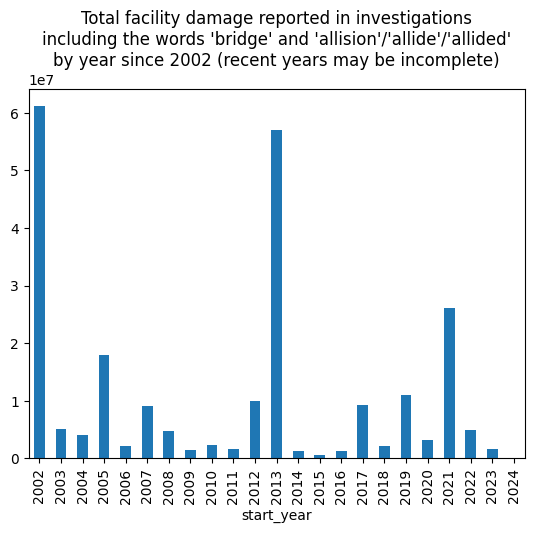

In [339]:
allisions_since_2002[allisions_since_2002["facility_damage"]>0].groupby(allisions_since_2002["start_year"])["facility_damage"].sum().plot(kind="bar", title="Total facility damage reported in investigations\nincluding the words 'bridge' and 'allision'/'allide'/'allided'\nby year since 2002 (recent years may be incomplete)")

In [331]:
allisions_since_2002[allisions_since_2002["start_year"]==2019]["facility_damage"].max()

4800000.0

In [328]:
allisions_since_2002[allisions_since_2002["facility_damage"]==60000000]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
96,1635967,M/V ROBERT Y LOVE/I-40 Hwy Bridge - Allision,2002-05-26,2007-11-06,10,27.0,NaN,27.0,27.0,NaN,...,273000.0,1176176.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,For the reasons detailed fully in the Investig...,2002


In [330]:
allisions_since_2002[allisions_since_2002["facility_damage"]==50000000]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
2153,4589867,M/V HERBERT C. JACKSON / Allision,2013-05-12,2015-01-09,216,0.0,NaN,NaN,NaN,NaN,...,5000.0,0.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,"On 12 May 2013, at approx 0150, SS HERBERT C. ...",2013


In [332]:
allisions_since_2002[allisions_since_2002["facility_damage"]==4800000.0]

,activity_id,title,start_dt,end_dt,page,Not at Risk,"At Risk, Not Injured",Dead,Injured,,...,vessel_damage,other_damage,serious_marine_incident,marine_board_convened,invest_level,casualty_classification,incident_involvement,invest_type,brief,start_year
2885,6641910,RIVERS WILSON- Bridge allision,2019-03-08,2019-12-27,289,0.0,NaN,NaN,NaN,NaN,...,65000.0,0.0,True,False,NaN,Major Marine Casualty,"Marine Casualty, Reportable",Incident Investigation,"On March 08, 2019 at approximately 2040, the 1...",2019


In [288]:
# SOAP request URL
url = "https://cgmix.uscg.mil/xml/IIRData.asmx"
BRIEF_SAVE_FILE = "data/source/IIR/IIR_brief.json"
 
# structured XML
def construct_brief_payload(activity_id):
    return f"""<?xml version="1.0" encoding="utf-8"?>
    <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
      <soap:Body>
        <getIIRIncidentBrief xmlns="https://cgmix.uscg.mil/xml/">
          <ActivityId>{activity_id}</ActivityId>
        </getIIRIncidentBrief>
      </soap:Body>
    </soap:Envelope>"""

# headers
SOAP_HEADERS = {
    'Content-Type': 'text/xml; charset=utf-8',
}
# POST request

def get_brief(activity_id):
    payload = construct_brief_payload(activity_id)
    response = requests.request("POST", url, data=payload,headers=SOAP_HEADERS)
    return bs4.BeautifulSoup(response.text,features="xml").find("IncidentBrief").text

def save_brief(activity_id):
    time.sleep(random.gauss(1,.1))
    try: 
      brief = get_brief(activity_id)
      df = pandas.DataFrame({"activity_id":[activity_id],"brief":[brief]})
      if os.path.exists(BRIEF_SAVE_FILE):
          df.to_json(BRIEF_SAVE_FILE,lines=True,orient="records",mode="a")
      else:
          df.to_json(BRIEF_SAVE_FILE,lines=True,orient="records",mode="w")
    except:
      print(f"Failed to get summary for activity {activity_id}")

if os.path.exists(BRIEF_SAVE_FILE):
    current_savefile = pandas.read_json(BRIEF_SAVE_FILE,lines=True,orient="records")
    activities_to_process = activities[~activities["activity_id"].isin(current_savefile["activity_id"])]
else:
    activities_to_process = activities

activities_to_process["activity_id"].apply(save_brief)

Failed to get summary for activity 3643247
Failed to get summary for activity 6833505
Failed to get summary for activity 7165562
Failed to get summary for activity 7412581
Failed to get summary for activity 7473218


KeyboardInterrupt: 

In [279]:
get_summary(456)

{'activity_id': 456,
 'serious_marine_incident': 'false',
 'marine_board_convened': 'false',
 'invest_level': None,
 'casualty_classification': 'Major Marine Casualty',
 'incident_involvement': 'Marine Casualty, Reportable',
 'invest_type': 'Incident Investigation'}

In [287]:
SUMMARY_SAVE_FILE = "data/source/IIR/IIR_summary.csv"

def construct_summary_payload(activity_id):
    return f"""<?xml version="1.0" encoding="utf-8"?>
            <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
              <soap:Body>
                <getIIRIncidentSummary xmlns="https://cgmix.uscg.mil/xml/">
                  <ActivityId>{activity_id}</ActivityId>
                </getIIRIncidentSummary>
              </soap:Body>
            </soap:Envelope>"""

def find_item_in_soup(soup,item):
    return soup.find(item).text if soup.find(item) else None

def get_summary(activity_id):
    payload = construct_summary_payload(activity_id)
    response = requests.request("POST", url, data=payload,headers=SOAP_HEADERS)
    soup = bs4.BeautifulSoup(response.text,features="xml")
    serious_marine_incident = find_item_in_soup(soup,"IsSeriousMarineIncident")
    marine_board_convened = find_item_in_soup(soup,"IsMarineBoardConvened")
    invest_level = find_item_in_soup(soup,"LevelofInvestigationLookupName")
    casualty_classification = find_item_in_soup(soup,"UnitedStatesMarineCasualtyClassificationLookupName")
    incident_involvement = find_item_in_soup(soup,"IncidentInvolvesLookupName")
    invest_type = find_item_in_soup(soup,"TypeLookupName")
    return {"activity_id":activity_id,
            "serious_marine_incident":serious_marine_incident,
            "marine_board_convened":marine_board_convened,
            "invest_level":invest_level,
            "casualty_classification":casualty_classification,
            "incident_involvement":incident_involvement,
            "invest_type":invest_type}

def save_csv(activity_id,savefile):
    time.sleep(random.gauss(1,.1))
    try: 
      summary = get_summary(activity_id)
      df = pandas.DataFrame([summary])
      if os.path.exists(savefile):
          df.to_csv(savefile,mode="a",header=False)
      else:
          df.to_csv(savefile,mode="w",header=True)
    except:
      print(f"Failed to get summary for activity {activity_id}")

if os.path.exists(SUMMARY_SAVE_FILE):
    current_savefile = pandas.read_csv(SUMMARY_SAVE_FILE)
    activities_to_process = activities[~activities["activity_id"].isin(current_savefile["activity_id"])]
else:
    activities_to_process = activities

activities_to_process["activity_id"].apply(save_csv,args=(SUMMARY_SAVE_FILE,))

Failed to get summary for activity 6889410


2610    None
2611    None
2612    None
2613    None
2614    None
        ... 
3627    None
3628    None
3629    None
3630    None
3631    None
Name: activity_id, Length: 1022, dtype: object

In [273]:
response.text

'<?xml version="1.0" encoding="utf-8"?><soap:Envelope xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema"><soap:Body><getIIRIncidentSummaryResponse xmlns="https://cgmix.uscg.mil/xml/"><getIIRIncidentSummaryResult><xs:schema id="NewDataSet" xmlns="" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:msdata="urn:schemas-microsoft-com:xml-msdata"><xs:element name="NewDataSet" msdata:IsDataSet="true" msdata:UseCurrentLocale="true"><xs:complexType><xs:choice minOccurs="0" maxOccurs="unbounded"><xs:element name="IIRIncidentSummary"><xs:complexType><xs:sequence><xs:element name="IsSeriousMarineIncident" type="xs:boolean" minOccurs="0" /><xs:element name="IsMarineBoardConvened" type="xs:boolean" minOccurs="0" /><xs:element name="LevelOfInvestigationLookupName" type="xs:string" minOccurs="0" /><xs:element name="InternationalMaritimeOrganizationIncidentTypeLookupName" type="xs:string" minOccurs="

In [260]:
pandas.DataFrame({"activity_id":[9147],"brief":[brief]}).to_json("data/source/IIR/test.json",lines=True,orient="records",mode="a")

In [261]:
pandas.read_json("data/source/IIR/IIR_brief.json",lines=True,orient="records")

,activity_id,brief,9147
0,9656,CFV MISS VERTIE MAE WAS INBOUND TO HAMPTON ROA...,NaN
1,9656,NaN,CFV MISS VERTIE MAE WAS INBOUND TO HAMPTON ROA...
2,9147,CFV MISS VERTIE MAE WAS INBOUND TO HAMPTON ROA...,NaN


In [ ]:
# save the response
with open("response.xml", "w") as f:
    f.write(response.text)

<table style="width: 950px; background-color: white; margin-left: auto; margin-right: auto;">
<tr>
<td colspan="3">
<table cellpadding="0" style="margin-left: auto; margin-right: auto; width: 950px">
<tr style="background-color: #000084">
<td align="left">
<a href="Default.aspx">
<img alt="Link to MARPOL Main Page" src="Images/XMLBanner.jpg" style="width: 950px;
                    height: 125px; border-bottom: solid; border-bottom-width: 0px"/></a>
<a href="#XMLHeader1_SPRMainMenu_SkipLink"><img alt="Skip Navigation Links" border="0" height="0" src="/XML/WebResource.axd?d=NJkROQsz4RVF0lBX0yl8n4xUgWGf3_ScesCTPnCalyJ8A4rX-iLYjrVHI8_1_oXUQvrQuHC_Zx-f_rTz0&amp;t=638368891540000000" width="0"/></a><table bgcolor="#000084" border="0" cellpadding="0" cellspacing="0" height="30" id="XMLHeader1_SPRMainMenu" width="250">
<tr>
<td id="XMLHeader1_SPRMainMenun0" onkeyup="Menu_Key(event)" onmouseout="Menu_Unhover(this)" onmouseover="Menu_HoverStatic(this)"><table bgcolor="#000084" border="0" cellpa